In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
# import ta|

import talib
import datetime
from tqdm import tqdm
import util_fun as uf
from datetime import timedelta,datetime

from kite_trade import *
from enctoken import get_kite
kite = get_kite()
from pandas.tseries.frequencies import to_offset

In [ ]:
# monthly above 60 
# weekly above 60 
# daily near 40 
# daily, hourly and 15 mins

In [ ]:
timerframe_list = [
"day",
"minute",
 "3minute",
 "5minute",
 "10minute",
 "15minute",
 "30minute",
 "60minute",]

# instument in nse
inst = pd.DataFrame(kite.instruments("NSE"))
inst_filter = inst.query('(name != "")').copy()
inst_filter.rename(columns = {"tradingsymbol":'Symbol'},inplace = True)
# inst_filter.query("Symbol. 'NIFTY'")
# inst_filter[inst_filter.Symbol.str.contains('HDFCBANK')]

nifty_500_df = pd.read_csv('../data/ind_nifty500list.csv')
nifty_500_df = nifty_500_df.merge(inst_filter, how = 'left', on = 'Symbol').dropna(subset = ["instrument_token"])
inst_dict = dict(zip(nifty_500_df.Symbol, nifty_500_df.instrument_token.astype(int)))

In [ ]:
# df_hour = pd.DataFrame(
#                         kite.historical_data(
#                             instrument_token=int(itoken),
#                             from_date="2023-08-01",
#                             to_date=end_dt,
#                             interval="60minute",
#                         )
# )
# df_hour

In [ ]:


def get_intraday_rsi_5star(sy, itoken,sht):
    # try
        df_15 = pd.DataFrame(
                        kite.historical_data(
                            instrument_token=int(itoken),
                            from_date=start_dt,
                            to_date=end_dt,
                            interval="15minute",
                        )
        )
        df_hour = pd.DataFrame(
                        kite.historical_data(
                            instrument_token=int(itoken),
                            from_date="2023-08-01",
                            to_date=end_dt,
                            interval="60minute",
                        )
        )
        df_day = pd.DataFrame(
                        kite.historical_data(
                            instrument_token=int(itoken),
                            from_date="2023-07-01",
                            to_date=end_dt,
                            interval="day",
                        )
        )

        df_15['rsi'] = talib.RSI(df_15['close'], timeperiod=14)
        df_hour['rsi'] = talib.RSI(df_hour['close'], timeperiod=14)
        df_day['rsi'] = talib.RSI(df_day['close'], timeperiod=14)

        df_15.set_index("date", inplace=True)
        df_15.index = df_15.index.tz_localize(None)
        df_15 = df_15.dropna().reset_index()
        df_hour.set_index('date', inplace = True)
        df_hour.index = df_hour.index.tz_localize(None)
        df_hour = df_hour.dropna().reset_index()

        df_15['hourly_date'] = np.where(df_15.date.dt.minute >= 15, pd.to_datetime(df_15.date.dt.strftime('%Y-%m-%d %H:15')),
                 pd.to_datetime(df_15.date.dt.strftime('%Y-%m-%d %H:15')) - pd.Timedelta(hours=1))
                 
        df_15['daily_date'] = pd.to_datetime(df_15['date'].dt.date)

        df_hour.rename(columns = {'date': 'hourly_date'}, inplace = True)
        df_day = df_day.assign(daily_date = pd.to_datetime(df_day.date.dt.date)).drop('date', axis = 1)
        
        # return df_15, df_hour, df_day
        df_merged = (
        df_15
        .merge(df_hour, how = 'left', on = 'hourly_date', suffixes=('_son','_father'))
        .merge(df_day, how = 'left', on = 'daily_date')
        .drop(['volume_son','volume_father','volume'],axis = 1)
        .dropna()
        .set_index('date')
        .rename(columns = {"rsi": 'rsi_grand_father'})
        )
        # return df_merged
        # df_merged['cond_1'] = np.where((df_merged['rsi_grand_father'] >= 60) & (df_merged['rsi_grand_father'] <= 80) &
        #        (df_merged['rsi_father']>= 60)  ,1,0 )
        # df_merged['cond_2'] = np.where((df_merged['rsi_son'] < 43),1,0 )
        # df_merged['buy'] =( (df_merged['cond_1'] ==1) &( df_merged['cond_2'] == 1))

        df_merged['cond_1'] = np.where((df_merged['rsi_grand_father'] >= 80) & (df_merged['rsi_grand_father'] <= 100),1,0)
        df_merged['cond_2'] = np.where((df_merged['rsi_father']>= 60)  ,1,0 )
        df_merged['cond_3'] = np.where((df_merged['rsi_son'] < 43),1,0 )
        df_merged['buy'] =((df_merged['cond_1'] ==1) &( df_merged['cond_2'] == 1) & ( df_merged['cond_3'] == 1))

        # df_merged['cond_1_sell'] = np.where((df_merged['rsi_grand_father'] <= 40) & (df_merged['rsi_grand_father'] >= 20) &
        #       (df_merged['rsi_father'] <= 40) ,1,0 )
        # df_merged['cond_2_sell'] = np.where((df_merged['rsi_son'] > 57),1,0 )
        # df_merged['sell'] =( (df_merged['cond_1_sell'] ==1) &( df_merged['cond_2_sell'] == 1))
        df_merged['cond_1_sell'] = np.where((df_merged['rsi_grand_father'] <= 20) & (df_merged['rsi_grand_father'] >= 0),1,0)
        df_merged['cond_2_sell'] = np.where((df_merged['rsi_father'] <= 40) ,1,0 )
        df_merged['cond_3_sell'] = np.where((df_merged['rsi_son'] > 57),1,0 )
        df_merged['sell'] =(df_merged['cond_1_sell'] ==1) &( df_merged['cond_2_sell'] == 1) & ( df_merged['cond_3_sell'] == 1)

        df_merged['symbol'] = sy
        return df_merged#[df_merged['buy']].assign(symbol = sy)
    # except:
    #     print('error: ', sy)

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import time
import xlwings

start_dt = "2023-08-09"
end_dt = "2023-08-11"
# return n dict pair
# def get_n_dict_pair(n, dict):
#     return {k: dict[k] for k in list(dict.keys())[:n]}

# results = Parallel(n_jobs=2, backend = 'threading')(delayed(get_intraday_rsi_5star)(sy, itoken) for sy, itoken in tqdm(get_n_dict_pair(100, inst_dict).items()))
# df_final = pd.concat(results)
wb = xlwings.Book(r'D:\US\McD-Discount-Portal\mcdds\notebooks\akash_dev\test.xlsx')
sht = wb.sheets['buy_sell']
current_time = 0
while True:
    if current_time%5 == 0: 
        time.sleep(5) 
        df_final = pd.DataFrame()

        for sy, itoken in tqdm(inst_dict.items()):
            try:
                df_final = df_final.append(get_intraday_rsi_5star(sy, itoken,sht))
            except:
                print(sy)
                continue
            # break

        
        df_final = df_final.query('daily_date == @end_dt and close <=2000')
        df_final.to_csv(f'data/test_11_aug_{datetime.now().strftime("%H_%M")}.csv')
        sht.clear_contents()
        sht.range('A1').value = df_final[df_final['buy']].sort_index()[['close','symbol']]
        sht.range('E1').value = df_final[df_final['sell']].sort_index()[['close','symbol']]
        # break
        # time.sleep(60*5)
    break
    current_time = datetime.now().minute

In [ ]:
## break last 1 year high
start_dt = '2022-07-01'
end_dt = '2023-08-11'
df_day = pd.DataFrame()

for sy, itoken in tqdm(inst_dict.items()):
    df_day = df_day.append(pd.DataFrame(
                            kite.historical_data(
                                instrument_token=int(itoken),
                                from_date="2022-07-01",
                                to_date=end_dt,
                                interval="day",
                            )
            ).assign(symbol=sy)
    )

In [ ]:
df_day.set_index("date", inplace=True)
df_day.index = df_day.index.tz_localize(None)
df_day.reset_index(inplace = True)

In [ ]:
df_year_back = df_day.query('date != "2023-08-11"')
df_today = df_day.query('date == "2023-08-11"')
df_year_back = df_year_back.groupby('symbol')['close'].max().reset_index()
df_today.merge(df_year_back, on = 'symbol').assign(flag = lambda x: x['close_x'] > x['close_y']).query('flag == True').symbol.unique()

In [ ]:
def is_consolidating(df):
    recent_closes = df.copy()

    max_close = recent_closes["close"].max()
    min_close = recent_closes["close"].min()
    # print("the max close {} and min close {}".format(max_close, min_close))
    if min_close > (max_close * 0.98):
        # print("is consolidating {}".format(set(recent_closes['stock'])))
        return True
    return False

def is_breaking_out(df):
    last_close = df[-1:]["close"].values[0]

    if is_consolidating(df[:-1]):
        recent_closes = df[-8:-1]
        if last_close > recent_closes["high"].max():
            print("is breaking {}".format(set(recent_closes["symbol"])))
            breakout_up.extend(list(set(recent_closes["symbol"])))
            return True
        if last_close < recent_closes["low"].min():
            print("is breaking  below {}".format(set(recent_closes["symbol"])))
            breakout_below.extend(list(set(recent_closes["symbol"])))
            return True
    return False

In [ ]:
breakout_up = []
breakout_below = []
df_breakout = df_day.groupby("symbol").apply(is_breaking_out).reset_index()
df_breakout.rename(columns = {0:'flag'}).query('flag == True')

In [ ]:
df_day.query('date != "2023-08-11" and date >= "2023-08-01"').groupby('symbol').apply(is_consolidating) \
.reset_index().rename(columns = {0:'flag'}).query('flag == True').symbol.unique()

## RNN

In [83]:
df_day.rename(columns={'close':'Close'}, inplace=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load your stock price 
# For this example, let's assume you have a CSV file with a 'Close' column representing the closing prices.

prices = df_day.query('symbol == "HDFCBANK"')['open'].values.reshape(-1, 1)

# Normalize the 
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# Create sequences for time series prediction
sequence_length = 10  # Number of past time steps to consider
sequences = []
targets = []

for i in range(len(scaled_prices) - sequence_length):
    sequences.append(scaled_prices[i:i+sequence_length])
    targets.append(scaled_prices[i+sequence_length])

X = np.array(sequences)
y = np.array(targets)

# Split the  into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f"Mean Squared Error: {mse}")

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(y_pred_original, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()


## suport and resistance

Support Levels: [(2, 648.5), (7, 676.2), (10, 662.2), (17, 706.45), (20, 724.75), (22, 730.45), (24, 721.6), (27, 739.0), (34, 741.85), (37, 743.35), (39, 728.7), (41, 744.15), (44, 750.0), (52, 789.3), (60, 716.45), (63, 722.75), (71, 800.5), (75, 825.85), (78, 902.85), (80, 903.05), (83, 863.55), (88, 843.7), (92, 855.4), (105, 899.2), (109, 933.7), (114, 935.1), (119, 906.6), (122, 924.7), (124, 933.75), (129, 939.9), (135, 913.15), (146, 857.25), (154, 859.1), (161, 833.35), (165, 844.1), (167, 845.45), (173, 832.35), (175, 824.05), (184, 832.45), (190, 847.35), (192, 851.05), (195, 863.35), (198, 864.2), (200, 878.35), (203, 860.0), (205, 859.85), (207, 865.3), (216, 914.7), (219, 916.15), (225, 914.85), (231, 962.1), (233, 974.2), (236, 977.15), (238, 965.65), (240, 966.0), (242, 958.4), (249, 966.5), (254, 950.0), (256, 957.05), (258, 963.65), (261, 971.3), (263, 962.5), (266, 949.95), (270, 935.55), (272, 947.4)]
Resistance Levels: [(1, 654.35), (6, 679.85), (8, 679.9), (15, 73

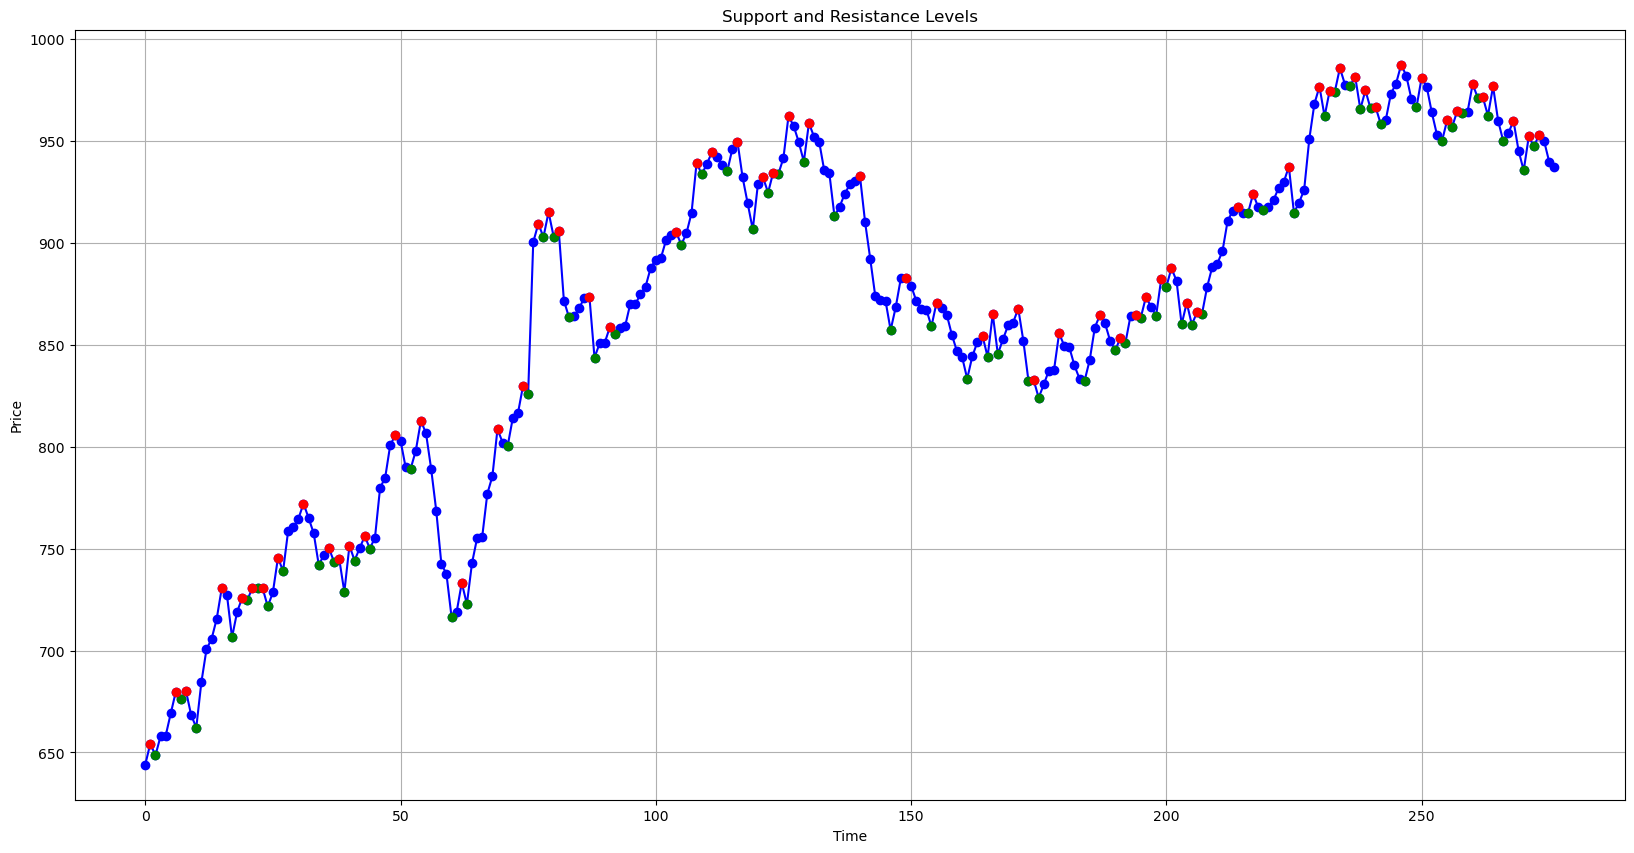

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Sample price data (replace this with your own price data)
price_data = df_day.query('symbol == "AXISBANK"')['Close'].values

def find_support_resistance(data, sensitivity=0.03):
    support_levels = []
    resistance_levels = []

    for i in range(1, len(data) - 1):
        if data[i - 1] > data[i] < data[i + 1]:  # Trough
            support_levels.append((i, data[i]))

        if data[i - 1] < data[i] > data[i + 1]:  # Peak
            resistance_levels.append((i, data[i]))

    # Filter out levels that are too close to each other
    filtered_support = []
    for level in support_levels:
        if all(abs(level[0] - s[0]) > sensitivity * len(data) for s in resistance_levels):
            filtered_support.append(level)

    filtered_resistance = []
    for level in resistance_levels:
        if all(abs(level[0] - r[0]) > sensitivity * len(data) for r in support_levels):
            filtered_resistance.append(level)
    return support_levels, resistance_levels
    return filtered_support, filtered_resistance

support_levels, resistance_levels = find_support_resistance(price_data)

print("Support Levels:", support_levels)
print("Resistance Levels:", resistance_levels)

# Plot the price data and identified levels
plt.figure(figsize=(20, 10))
plt.plot(price_data, marker='o', linestyle='-', color='b', label='Price',)
for level in support_levels:
    plt.plot(level[0], level[1], marker='o', color='g', label='Support Level')
for level in resistance_levels:
    plt.plot(level[0], level[1], marker='o', color='r', label='Resistance Level')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Support and Resistance Levels')
# plt.legend()

plt.grid()
plt.show()


In [113]:
import plotly.graph_objects as go

fig = go.Figure()

# Create the price data trace
price_trace = go.Scatter(
    x=list(range(len(price_data))),
    y=price_data,
    mode='lines+markers',
    line=dict(color='blue'),
    marker=dict(color='blue'),
    name='Price'
)
fig.add_trace(price_trace)

# Create support levels traces
for level in support_levels:
    support_trace = go.Scatter(
        x=[level[0]],
        y=[level[1]],
        mode='markers',
        marker=dict(color='green'),
        name='Support Level'
    )
    fig.add_trace(support_trace)

# Create resistance levels traces
for level in resistance_levels:
    resistance_trace = go.Scatter(
        x=[level[0]],
        y=[level[1]],
        mode='markers',
        marker=dict(color='red'),
        name='Resistance Level'
    )
    fig.add_trace(resistance_trace)

fig.update_layout(
    title='Support and Resistance Levels',
    xaxis_title='Time',
    yaxis_title='Price',
    showlegend=True,
    # grid=dict(visible=True),
)

fig.show()


Swing Highs and Lows: []


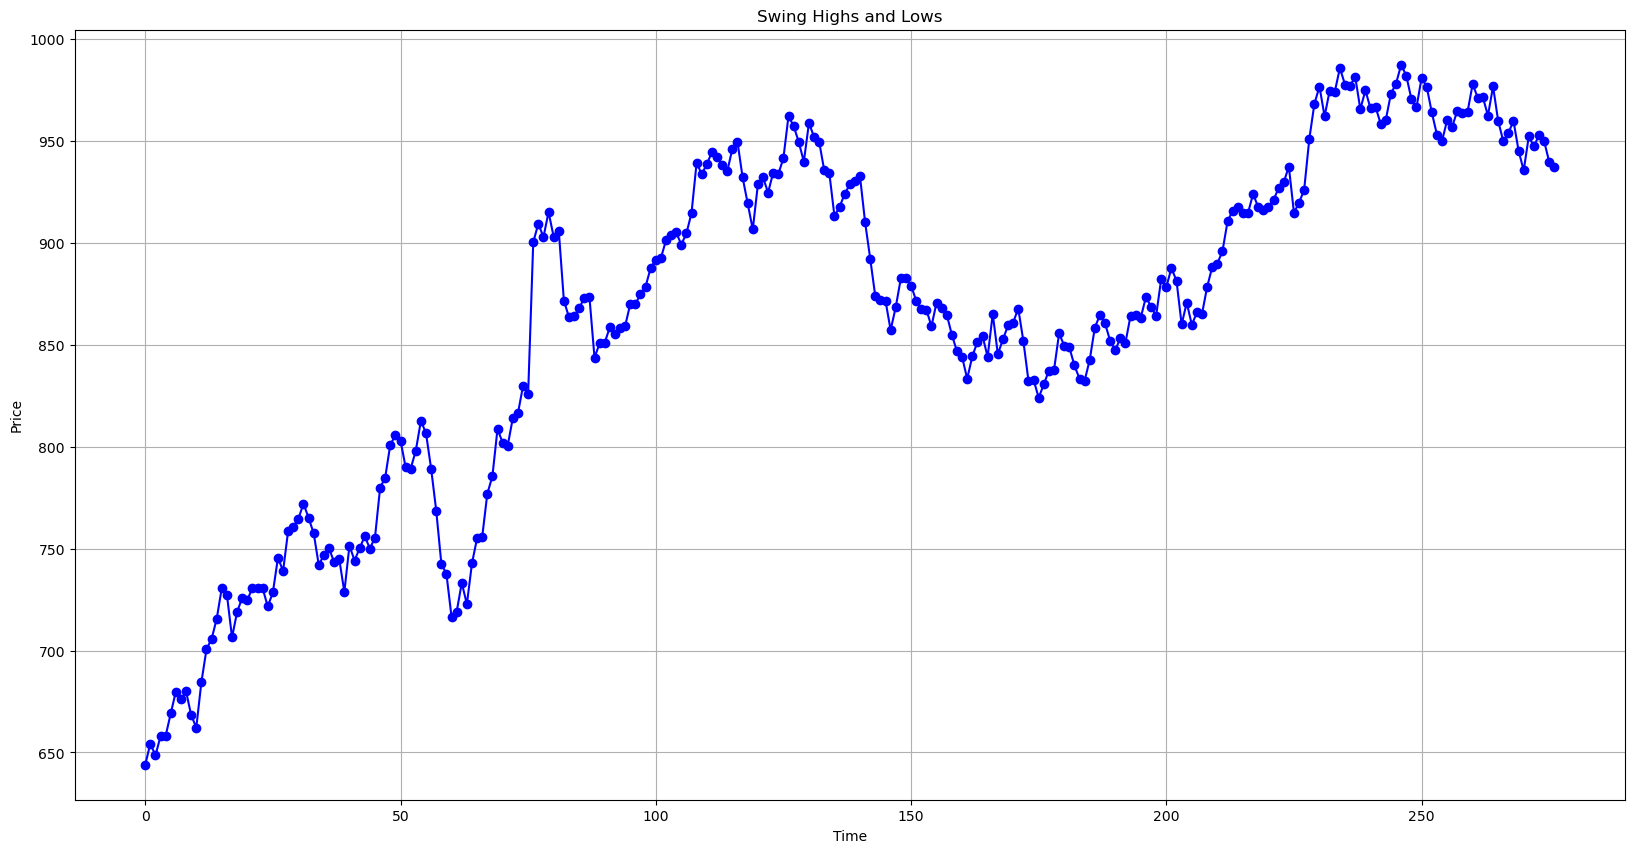

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Sample price data (replace this with your own price data)
price_data = df_day.query('symbol == "AXISBANK"')['Close'].values
def find_swing_highs_lows(data, sensitivity=0.03):
    swing_highs = []
    swing_lows = []

    for i in range(1, len(data) - 1):
        if data[i - 1] < data[i] > data[i + 1]:  # Swing High
            swing_highs.append((i, data[i]))

        if data[i - 1] > data[i] < data[i + 1]:  # Swing Low
            swing_lows.append((i, data[i]))

    # Filter out levels that are too close to each other
    filtered_swings = []
    for high in swing_highs:
        if all(abs(high[0] - low[0]) > sensitivity * len(data) for low in swing_lows):
            filtered_swings.append(high)

    for low in swing_lows:
        if all(abs(low[0] - high[0]) > sensitivity * len(data) for high in swing_highs):
            filtered_swings.append(low)

    return filtered_swings

swing_levels = find_swing_highs_lows(price_data)

print("Swing Highs and Lows:", swing_levels)

# Plot the price data and identified swing levels
plt.figure(figsize=(20, 10))
plt.plot(price_data, marker='o', linestyle='-', color='b', label='Price')
for level in swing_levels:
    plt.plot(level[0], level[1], marker='o', color='g', label='Swing Level')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Swing Highs and Lows')
# plt.legend()
plt.grid()
plt.show()
